# Exploratory Analysis Phishing_Email.csv Group 3

In [83]:
# Potentionally helpful libraries:
# pandas, matplotlib, seaborn, nltk, scikit-learn, gensim, pyLDAvis

import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sns

## Data Cleaning Function

In [84]:
#function now cleans the dataframe of null and empty emails and prints a pie chart that
# showcases the percent of null and empty emails vs. 'good' emails (non-null and anon-empty)
def make_df():
    # Reading in the data
    df = pd.read_csv("Phishing_Email.csv")
    # Dropping the unecessary index row
    df = df.drop(df.columns[0], axis=1)
    
    #calculate counts before cleaning
    num_rows = df.shape[0]
    num_nulls = df['Email Text'].isnull().sum()
    num_emptys = (df['Email Text'].str.lower() == 'empty').sum()
    num_not_empty_and_not_null = num_rows - num_nulls - num_emptys
    
    # Removing Nulls
    # Check for null values in the "Email Text" column
    null_mask = df["Email Text"].isnull()

    # If there are null values, drop the corresponding rows
    if null_mask.any():
        df = df.drop(df[null_mask].index)
        
    #Remove 'empty' emails from the dataframe
    df_cleaned = df[df['Email Text'].str.lower() != 'empty']
    df = df_cleaned
    
    #plotting data
    labels = 'Null Values', ' Empty Emails', 'Non-Empty and Non-Null Emails'
    sizes = [num_nulls, num_emptys, num_not_empty_and_not_null]
    colors = ['red', 'lightcoral', 'lightskyblue']
    explode = (0.1,0.1,0)   #explode 1st and 2nd labels, since their number is smaller compared to the third
    plt.figure(figsize=(10,6))
    plt.pie(sizes, explode=explode, labels=labels, colors=colors, shadow=True, startangle=140)
    plt.axis('equal')
    plt.title('Proportion of Null, Empty and Non-Null and Non-Empty emails in dataset')
    plt.show()
    
    return df

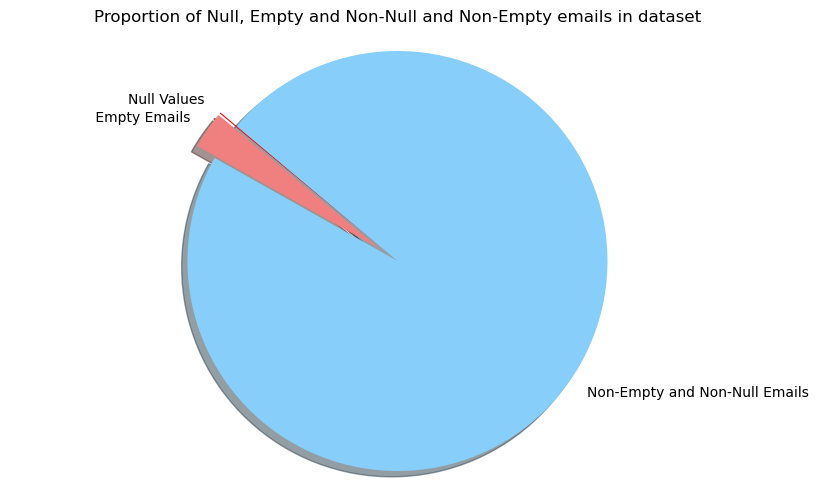

In [85]:
#gets cleaned dataframe and prints plot
df_phish = make_df()

As we can see the number of 'good' emails (non-empty and non-null) dominate the dataset. While the number of empty and null values in the dataset is very low, we make sure to take them out in order to avoid any issues with our feature extraction and analyses. It can also be seen that the proportion of null values as a whole is very miniscule compared to the proprtion of empty emails and good emails.

## Feature Extraction

### Emails with "re:"

In [86]:
print(df_phish.tail(5))

def countNaN(df):
    return (df["Email Text"] == "NaN").sum()

print(countNaN(df_phish))

                                              Email Text      Email Type
18644  \nRick Moen  a Ã©crit:> > I'm confused. I thou...      Safe Email
18645  date a lonely housewife always wanted to date ...  Phishing Email
18646  request submitted : access request for anita ....      Safe Email
18647  re : important - prc mtg hi dorn & john , as y...      Safe Email
18648  press clippings - letter on californian utilit...      Safe Email
0


In [ ]:
print(df_phish.tail(20))
# Adding "Is_Response" feature
df_phish["Is_Response"] = df_phish["Email Text"].str.contains("re :")
print(df_phish.tail(20))

In [88]:
df_phish["Is_Response"].value_counts(normalize=True)

Is_Response
False    0.866637
True     0.133363
Name: proportion, dtype: float64

### Emails with links

In [ ]:
# This is causing columns to turn into NaN values and losing data.

print(df_phish.tail(5))
# Adding "Has_WebLink" column
df_phish["Has_WebLink"] = df_phish["Email Text"].str.contains('(https?://|www.)')

print(df_phish.tail(5))
    

In [90]:
df_phish["Has_WebLink"].value_counts(normalize=True)

Has_WebLink
False    0.660682
True     0.339318
Name: proportion, dtype: float64

### Email Length

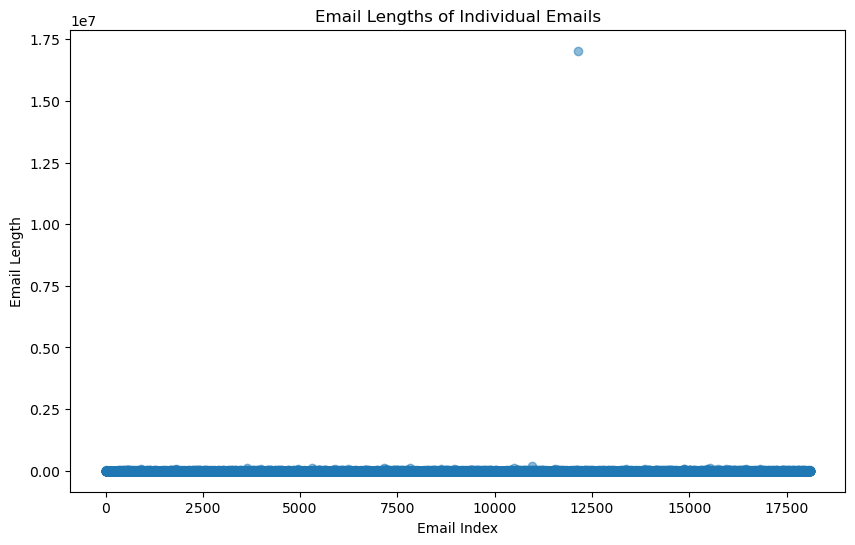

In [91]:
# print(df_phish.tail(5))

# Creating the Email Length Column
df_phish["Email_Length"] = df_phish["Email Text"].str.len()

#plotting scatter plot 
plt.figure(figsize=(10, 6))
plt.scatter(x=range(len(df_phish)), y=df_phish["Email_Length"], alpha=0.5)
plt.title('Email Lengths of Individual Emails')
plt.xlabel('Email Index')
plt.ylabel('Email Length')
plt.show()
    
# Verifying it worked
# print(df_phish.tail(5))


Initial drawing of the scatter plot shows that we have an outlier, which blasts the range of the plot into 10^7

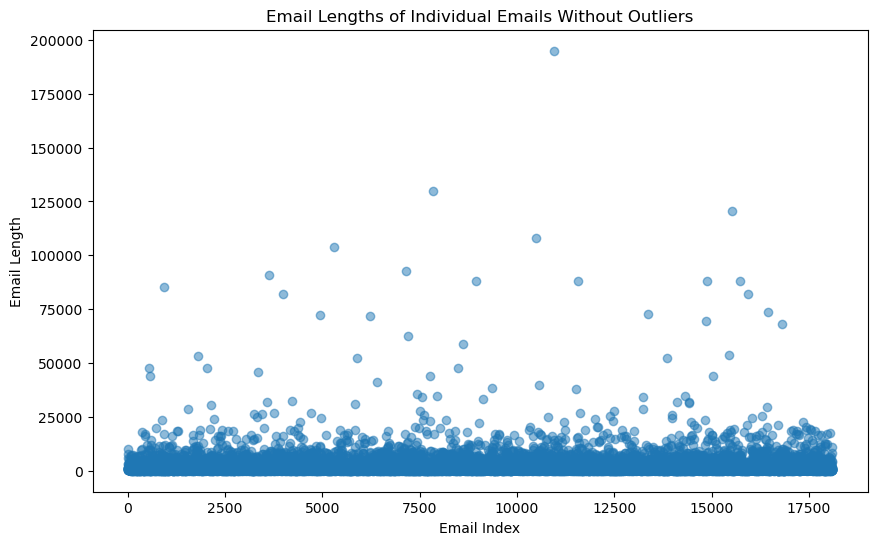

In [92]:

length_threshold = 0.2e7

# Filtering the DataFrame to exclude the outlier
df_filtered = df_phish[df_phish["Email_Length"] < length_threshold]

plt.figure(figsize=(10, 6))
plt.scatter(x=range(len(df_filtered)), y=df_filtered["Email_Length"], alpha=0.5, label='Emails')
plt.title('Email Lengths of Individual Emails Without Outliers')
plt.xlabel('Email Index')
plt.ylabel('Email Length')
plt.show()

As can be seen in this plot without the outlier, most of the emails in the dataset are under 25000 characters in length, while we have comparatively few emails larger than that

In [ ]:
print(df_phish.tail(10))

df_phish["Hyphen_Count"] = df_phish["Email Text"].str.count(r"-")
df_phish["Pound_Count"] = df_phish["Email Text"].str.count(r"#")
df_phish["At_Count"] = df_phish["Email Text"].str.count(r"@")

print(df_phish.tail(10))

In [ ]:
print(df_phish.tail(10))

df_phish["Exclamation_Count"] = df_phish["Email Text"].str.count(r"!")
df_phish["Question_Count"] = df_phish["Email Text"].str.count(r"\?")
df_phish["Period_Count"] = df_phish["Email Text"].str.count(r"\.")

print(df_phish.tail(10))

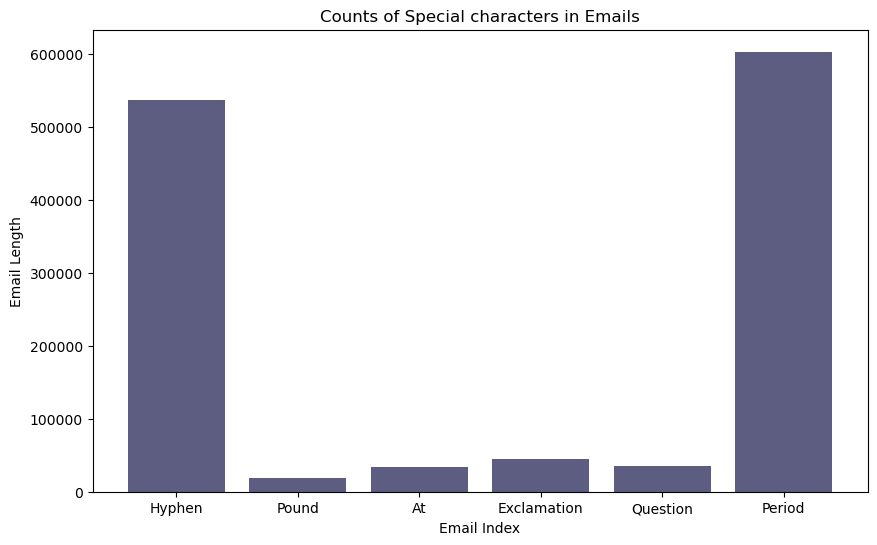

In [95]:
#creating a barchart for each special character category

#lists holds the labels and their respective counts
special_chars_labels = ["Hyphen","Pound", "At", "Exclamation", "Question", "Period"]
special_chars_labels_count = [df_phish["Hyphen_Count"].sum(), df_phish["Pound_Count"].sum(), df_phish["At_Count"].sum(),
                              df_phish["Exclamation_Count"].sum(), df_phish["Question_Count"].sum(), df_phish["Period_Count"].sum()]

plt.figure(figsize=(10,6))
plt.bar(special_chars_labels,special_chars_labels_count, color='#5D5D81')
plt.title('Counts of Special characters in Emails')
plt.xlabel('Email Index')
plt.ylabel('Email Length')
plt.show()

As this chart shows, period is the most popular special characters followed by hyphens.

### Emails with All-Caps characters over a certain percent threshold (8%) to determine safe or phishing emails

In [96]:
#writing a function that calculates the percent of upper and lowercase characters in an email

def percent_of_all_caps(text):
    if not text or not isinstance(text, str):
        return 0
    #getting rid of special characters from check for all-caps
    alphanumeric_text = re.sub(r'[^A-Za-z0-9]','',text)
    num_all_caps =  sum(1 for c in alphanumeric_text if c.isupper())
    num_total_characters = len(alphanumeric_text)
    #prevent divide by 0
    if(num_total_characters == 0):
        return 0
    percent_all_caps = (num_all_caps/num_total_characters)*100
    return percent_all_caps

#creating a new column in dataframe for percentage of capitalization and marking emails as safe or phishing
df_phish['Capitalization_Percent'] = df_phish['Email Text'].apply(percent_of_all_caps)

# I dont want to assume a percentage value that would be indicative of a phishing email or not just based on capitalization percentage.
# We should let the model determine that or make a graph showing at different percentages, what proportion of emails were correctly identified as phishing.
# df_phish['Is Phishing'] = df_phish['Capitalization_Percent'] > 8    #initially had as 55, looked at exported cleaned data to adjust to 8

#export in a CSV file to better compare my results on phishing classification vs. actual results
# temp_df = df_phish[['Email Text', 'Email Type', 'Capitalization_Percent', 'Is Phishing']]
#temp_df.to_csv('test.csv', index=False)
#print(temp_df)